# Air Route Optimizer

### 1. Setup & Configuration

In [105]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
import copy
import math

DATA_DIR = 'data'
RESULTS_DIR = 'results'

# Input file paths
AIRPORTS_FILE = os.path.join(DATA_DIR, 'airports.csv') # Contains airport coordinates and metadata
TRAFFIC_FILE = os.path.join(DATA_DIR, 'traffic_demand.csv') # Contains origin-destination traffic demand data

# Hyperparameters for optimization and clustering
OPTIMAL_K_SEARCH_RANGE = range(100, 50, -1)  # for k-means clustering with k values
FLUX_THRESHOLD = 100  # Maximum allowable traffic (flux) per air traffic control sector
OPTIMIZATION_ITERATIONS = 50  # Number of iterations to fine-tune sector boundaries
COST_STEP = 0.01  # Step size for movements intended to reduce overall cost
DANGER_STEP = 0.05  # Step size for movements intended to reduce "danger"

os.makedirs(RESULTS_DIR, exist_ok=True) # Create output directory if it doesn't already exist

print("Air Route Optimizer Initialized")
print(f"Results will be saved to: {RESULTS_DIR}")

Air Route Optimizer Initialized
Results will be saved to: results


### 2. Some Helpers

- `load_data()` – Loads and parses airport coordinates and traffic demand from CSV files. It constructs a matrix representing the daily traffic between all airport pairs.

- `calculate_intersection()` – Computes the intersection point of two line segments using vector cross products. This helps detect route crossings in the airspace.

- `plot_network()` – Visualizes the air route network including airports, traffic routes, and intersection points. Supports labeling and saving the plot to a file.

In [106]:
def load_data(airport_path, traffic_path):
    """
    Load airport positions and traffic demand data from CSV files.
    
    Args:
        airport_path (str): Path to airports CSV file
        traffic_path (str): Path to traffic demand CSV file
        
    Returns:
        tuple: (airport_positions, traffic_demand, airport_codes)
            - airport_positions (list): [[x, y], ...] coordinates for each airport
            - traffic_demand (np.ndarray): NxN matrix of daily traffic demand
            - airport_codes (list): Airport IATA codes
    """
    try:
        df_airports = pd.read_csv(airport_path)
        df_traffic = pd.read_csv(traffic_path)
    except FileNotFoundError as e:
        print(f"Error loading data files: {e}")
        print("Please ensure the data directory contains 'airports.csv' and 'traffic_demand.csv'")
        return None, None, None
    
    # Extract airport data
    airport_positions = df_airports[['coordinate_x', 'coordinate_y']].values.tolist()
    airport_codes = df_airports['code'].tolist()
    
    # Build traffic demand matrix
    num_airports = len(airport_codes)
    code_to_idx = {code: i for i, code in enumerate(airport_codes)}
    
    traffic_demand = np.zeros((num_airports, num_airports), dtype=int)
    for _, row in df_traffic.iterrows():
        if row['origin'] in code_to_idx and row['destination'] in code_to_idx:
            orig_idx = code_to_idx[row['origin']]
            dest_idx = code_to_idx[row['destination']]
            traffic_demand[orig_idx, dest_idx] = row['traffic']
    
    print(f"Loaded {num_airports} airports and {len(df_traffic)} traffic routes")
    return airport_positions, traffic_demand, airport_codes

def calculate_intersection(s1_pts, s2_pts):
    """
    Calculate intersection point of two line segments using vector cross products.
    Robust method that avoids division-by-zero errors for vertical lines.
    
    Args:
        s1_pts (list): Endpoints of segment 1: [[x1, y1], [x2, y2]]
        s2_pts (list): Endpoints of segment 2: [[x3, y3], [x4, y4]]
        
    Returns:
        list or None: [x, y] coordinates of intersection, or None if no intersection
    """
    p1, p2 = s1_pts
    p3, p4 = s2_pts
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    # Calculate denominator for parametric intersection
    den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if abs(den) < 1e-10:  # Lines are parallel or collinear
        return None

    # Calculate parametric coordinates
    t_num = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)
    u_num = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3))
    t = t_num / den
    u = u_num / den

    # Check if intersection is within both segments (excluding endpoints)
    if 0 < t < 1 and 0 < u < 1:
        x_inter = x1 + t * (x2 - x1)
        y_inter = y1 + t * (y2 - y1)
        return [x_inter, y_inter]
    
    return None

def plot_network(positions, routes, airport_codes, title="Air Route Network", 
                save_path=None, figsize=(14, 10)):
    """
    Plot the air route network.
    
    Args:
        positions (list): Node positions [[x, y], ...]
        routes (list): Route connections [[node1, node2], ...]
        airport_codes (list): Airport IATA codes for labeling
        title (str): Plot title
        save_path (str): Optional path to save figure
        figsize (tuple): Figure size
    """
    pos_arr = np.array(positions)
    num_airports = len(airport_codes)
    
    plt.figure(figsize=figsize)
    
    # Plot routes
    for route in routes:
        p1 = positions[route[0]]
        p2 = positions[route[1]]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                color='lightblue', linewidth=0.8, alpha=0.7, zorder=1)
    
    # Plot airports
    plt.scatter(pos_arr[:num_airports, 0], pos_arr[:num_airports, 1], 
               c='darkblue', s=80, zorder=3, label='Airports', edgecolors='white', linewidth=1)
    
    # Plot intersections if present
    if len(pos_arr) > num_airports:
        plt.scatter(pos_arr[num_airports:, 0], pos_arr[num_airports:, 1], 
                   c='red', s=15, zorder=2, label='Intersections', alpha=0.8)
    
    # Label airports
    for i, code in enumerate(airport_codes):
        plt.annotate(code, (pos_arr[i, 0], pos_arr[i, 1]), 
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold', color='darkblue')
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("X Coordinate (m)", fontsize=12)
    plt.ylabel("Y Coordinate (m)", fontsize=12)
    plt.legend(loc='upper right', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Format axes
    ax = plt.gca()
    ax.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

### 3. Building Initial Air Route Network
- `determine_initial_trajectories()`: Identifies initial direct flight trajectories between airport pairs that have non-zero traffic in either direction.

- `create_initial_network()`: Builds a realistic route network by detecting and modeling intersections between crossing trajectories. It ensures air routes are properly segmented at crossing points to improve route clarity and later optimization.

- `create_adjacency_matrix()`: Generates an adjacency matrix representing the connectivity of the air route network, which is essential for graph-based computations like shortest paths.

In [107]:
def determine_initial_trajectories(traffic_demand):
    """
    Determine initial trajectories based on traffic demand.
    A trajectory [i, j] exists if there's non-zero traffic in either direction.
    
    Args:
        traffic_demand (np.ndarray): NxN traffic demand matrix
        
    Returns:
        list: List of trajectory pairs [[i, j], ...]
    """
    num_airports = traffic_demand.shape[0]
    trajectories = []
    
    for i in range(num_airports):
        for j in range(i + 1, num_airports):
            if traffic_demand[i, j] > 0 or traffic_demand[j, i] > 0:
                trajectories.append([i, j])
    
    print(f"Generated {len(trajectories)} initial trajectories")
    return trajectories

def create_initial_network(airport_positions, trajectories):
    """
    Build initial route network by finding all trajectory intersections efficiently.
    
    Args:
        airport_positions (list): Airport coordinates
        trajectories (list): Initial trajectory pairs
        
    Returns:
        tuple: (all_positions, final_routes)
            - all_positions (list): Combined airport and intersection positions
            - final_routes (list): Final route connections
    """
    print("Building initial network by finding intersections...")
    print(f"   Processing {len(trajectories)} initial trajectories...")
    
    all_positions = copy.deepcopy(airport_positions)
    intersections = []
    intersection_map = {}  # Maps (traj1_idx, traj2_idx) -> intersection_idx
    
    # Find all intersections between trajectory pairs
    print("   Finding trajectory intersections...")
    for i in range(len(trajectories)):
        for j in range(i + 1, len(trajectories)):
            traj1 = trajectories[i]
            traj2 = trajectories[j]
            
            # Skip if trajectories share an endpoint
            if (traj1[0] in traj2) or (traj1[1] in traj2):
                continue
            
            # Get segment endpoints
            s1_pts = [airport_positions[traj1[0]], airport_positions[traj1[1]]]
            s2_pts = [airport_positions[traj2[0]], airport_positions[traj2[1]]]
            
            intersection_pos = calculate_intersection(s1_pts, s2_pts)
            
            if intersection_pos:
                intersection_idx = len(all_positions)
                all_positions.append(intersection_pos)
                intersections.append({
                    'position': intersection_pos,
                    'trajectories': [(i, traj1), (j, traj2)],
                    'idx': intersection_idx
                })
                intersection_map[(i, j)] = intersection_idx
        
        # Progress indicator
        if (i + 1) % 10 == 0 or i == len(trajectories) - 1:
            print(f"   Progress: {i + 1}/{len(trajectories)} trajectories processed")
    
    print(f"   Found {len(intersections)} intersections")
    
    # Build final route network
    print("   Building route network...")
    final_routes = []
    
    # Add direct routes that don't have intersections
    for i, traj in enumerate(trajectories):
        has_intersection = False
        for (traj_i, traj_j), _ in intersection_map.items():
            if i == traj_i or i == traj_j:
                has_intersection = True
                break
        
        if not has_intersection:
            final_routes.append(traj)
    
    # Add routes through intersections
    for intersection in intersections:
        intersection_idx = intersection['idx']
        for traj_idx, traj in intersection['trajectories']:
            # Connect each trajectory endpoint to the intersection
            final_routes.append([traj[0], intersection_idx])
            final_routes.append([traj[1], intersection_idx])
    
    # Remove duplicate routes
    unique_routes = []
    route_set = set()
    for route in final_routes:
        route_tuple = tuple(sorted(route))
        if route_tuple not in route_set:
            route_set.add(route_tuple)
            unique_routes.append(route)
    
    final_routes = unique_routes
    
    print(f"Network generation complete:")
    print(f"   • Initial trajectories: {len(trajectories)}")
    print(f"   • Intersections found: {len(intersections)}")
    print(f"   • Total nodes: {len(all_positions)}")
    print(f"   • Final routes: {len(final_routes)}")
    
    return all_positions, final_routes

def create_adjacency_matrix(positions, routes):
    """
    Create adjacency matrix representation of the network.
    
    Args:
        positions (list): Node positions
        routes (list): Route connections
        
    Returns:
        np.ndarray: Adjacency matrix (symmetric)
    """
    num_nodes = len(positions)
    network_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    
    for i, j in routes:
        network_matrix[i, j] = 1
        network_matrix[j, i] = 1
    
    return network_matrix

### 3. Route Metrics and Network Evaluation
- `calculate_route_distances()`: Computes the pairwise Euclidean distances between connected nodes in the network, forming the basis for cost and pathfinding calculations.

- `calculate_route_flux()`: Calculates the traffic (aircraft flux) on each route by routing all demand over the shortest available paths. Uses the Floyd-Warshall algorithm to ensure optimal routing for every airport pair.

- `reconstruct_path()`: Helper function used by calculate_route_flux() to reconstruct the actual sequence of nodes from the predecessor matrix returned by Floyd-Warshall.

- `evaluate_airline_cost()`: Computes the total operational cost for airlines, defined as the sum of distance multiplied by traffic on each route.

- `evaluate_network_dangerousness()`: Measures the complexity of managing the air traffic network based on geometric angles and intersecting traffic at control points. Higher values indicate more challenging traffic scenarios for air traffic control.

In [108]:
def calculate_route_distances(positions, network_matrix):
    """
    Calculate Euclidean distances for all routes in the network.
    
    Args:
        positions (list): Node positions
        network_matrix (np.ndarray): Adjacency matrix
        
    Returns:
        np.ndarray: Distance matrix (same shape as network_matrix)
    """
    num_nodes = len(positions)
    dist_matrix = np.zeros((num_nodes, num_nodes), dtype=float)
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if network_matrix[i, j] == 1:
                dist = np.linalg.norm(np.array(positions[i]) - np.array(positions[j]))
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
    
    return dist_matrix

def calculate_route_flux(traffic_demand, initial_trajectories, distance_matrix):
    """
    Calculate aircraft flux on each route using shortest paths (Floyd-Warshall).
    
    Args:
        traffic_demand (np.ndarray): Airport-to-airport traffic demand
        initial_trajectories (list): Original trajectory pairs
        distance_matrix (np.ndarray): Route distances
        
    Returns:
        np.ndarray: Flux matrix showing aircraft count on each route
    """
    num_nodes = distance_matrix.shape[0]
    flux_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    
    # Prepare graph for Floyd-Warshall (use infinity for non-edges)
    graph = np.where(distance_matrix > 0, distance_matrix, np.inf)
    np.fill_diagonal(graph, 0)
    
    # Find shortest paths
    dist_csr = csr_matrix(graph)
    _, predecessors = floyd_warshall(dist_csr, directed=False, return_predecessors=True)
    
    # Route traffic along shortest paths
    for i, j in initial_trajectories:
        # Route traffic from i to j
        if traffic_demand[i, j] > 0:
            path = reconstruct_path(predecessors, i, j)
            for k in range(len(path) - 1):
                flux_matrix[path[k], path[k+1]] += traffic_demand[i, j]
        
        # Route traffic from j to i
        if traffic_demand[j, i] > 0:
            path = reconstruct_path(predecessors, j, i)
            for k in range(len(path) - 1):
                flux_matrix[path[k], path[k+1]] += traffic_demand[j, i]
    
    return flux_matrix

def reconstruct_path(predecessors, start, end):
    """
    Reconstruct shortest path from predecessors matrix.
    
    Args:
        predecessors (np.ndarray): Predecessors from Floyd-Warshall
        start (int): Start node
        end (int): End node
        
    Returns:
        list: Path as sequence of node indices
    """
    path = []
    current = end
    
    while current != start:
        path.append(current)
        prev = predecessors[start, current]
        if prev == -9999:  # No path exists
            return []
        current = prev
    
    path.append(start)
    return list(reversed(path))

def evaluate_airline_cost(distance_matrix, flux_matrix):
    """
    Calculate total airline operational cost (distance × traffic).
    
    Args:
        distance_matrix (np.ndarray): Route distances
        flux_matrix (np.ndarray): Route traffic flows
        
    Returns:
        float: Total cost metric
    """
    return np.sum(distance_matrix * flux_matrix)

def evaluate_network_dangerousness(positions, num_airports, network_matrix, flux_matrix):
    """
    Calculate ATC 'dangerousness' based on intersection geometry and traffic.
    Higher values indicate more complex air traffic control scenarios.
    
    Args:
        positions (list): Node positions
        num_airports (int): Number of airports (intersections start after this)
        network_matrix (np.ndarray): Network adjacency matrix
        flux_matrix (np.ndarray): Traffic flows
        
    Returns:
        float: Dangerousness metric
    """
    dangerousness = 0.0
    num_nodes = len(positions)
    
    # Iterate over intersections only (not airports)
    for k in range(num_airports, num_nodes):
        neighbors = np.where(network_matrix[k, :] == 1)[0]
        
        # Consider all pairs of routes meeting at this intersection
        for i_idx in range(len(neighbors)):
            for j_idx in range(i_idx + 1, len(neighbors)):
                i, j = neighbors[i_idx], neighbors[j_idx]
                
                flux_ik = flux_matrix[i, k] + flux_matrix[k, i]
                flux_jk = flux_matrix[j, k] + flux_matrix[k, j]
                
                if flux_ik > 0 and flux_jk > 0:
                    # Calculate angle between routes at intersection
                    vec_ki = np.array(positions[i]) - np.array(positions[k])
                    vec_kj = np.array(positions[j]) - np.array(positions[k])
                    
                    norm_ki = np.linalg.norm(vec_ki)
                    norm_kj = np.linalg.norm(vec_kj)
                    
                    if norm_ki > 1e-10 and norm_kj > 1e-10:
                        cos_angle = np.dot(vec_ki, vec_kj) / (norm_ki * norm_kj)
                        cos_angle = np.clip(cos_angle, -1.0, 1.0)
                        angle = np.arccos(cos_angle)
                        
                        cos_half_angle = np.cos(angle / 2)
                        if cos_half_angle > 1e-9:
                            # Dangerousness increases with traffic and decreases with angle
                            dangerousness += (flux_ik * flux_jk) / cos_half_angle
    
    return dangerousness


### 4. Sectorization via Intersection Clustering and Flux Evaluation
This section implements control sector optimization by clustering intersection points and evaluating traffic distribution to ensure manageable ATC workloads:
- `partition_intersections()`: Uses k-means clustering to group intersection points into k clusters. Each cluster represents a potential air traffic control sector centered at the cluster centroid.

- `create_reduced_network()`: Builds a simplified (reduced) version of the route network by mapping original intersection nodes to their respective cluster centers. This approximates sector-level route structures.

- `calculate_sector_flux()`: Calculates the total aircraft flux through each clustered intersection sector by summing all connected traffic routes, providing a measure of sector workload.

- `find_optimal_k()`: Searches for the smallest number of sectors (clusters) that keeps the maximum traffic flux within a specified threshold. It tests multiple values of k (using binary search for large ranges) and returns the first k that satisfies the constraint.

This part is critical for ensuring that the air route design is not only efficient for airlines but also manageable and safe for controllers, balancing system-wide throughput with human workload constraints.


In [ ]:
def partition_intersections(intersection_positions, k):
    """
    Partition intersection points into k clusters using k-means.
    
    Args:
        intersection_positions (np.ndarray): Intersection coordinates
        k (int): Number of clusters
        
    Returns:
        tuple: (cluster_centers, labels)
    """
    if len(intersection_positions) == 0:
        return np.array([]), np.array([])
    
    if k >= len(intersection_positions):
        return intersection_positions, np.arange(len(intersection_positions))
    
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(intersection_positions)
    
    return kmeans.cluster_centers_, kmeans.labels_

def create_reduced_network(airport_positions, new_intersection_positions, labels, 
                          initial_network_matrix):
    """
    Create reduced network by mapping old intersections to cluster centers.
    
    Args:
        airport_positions (list): Airport coordinates
        new_intersection_positions (np.ndarray): Cluster centers
        labels (np.ndarray): Cluster assignments for old intersections
        initial_network_matrix (np.ndarray): Original network adjacency matrix
        
    Returns:
        np.ndarray: Reduced network adjacency matrix
    """
    num_airports = len(airport_positions)
    num_new_intersections = len(new_intersection_positions)
    num_initial_nodes = initial_network_matrix.shape[0]
    num_reduced_nodes = num_airports + num_new_intersections
    
    reduced_network = np.zeros((num_reduced_nodes, num_reduced_nodes), dtype=int)
    
    # Map edges from old network to new network
    for i in range(num_initial_nodes):
        for j in range(i + 1, num_initial_nodes):
            if initial_network_matrix[i, j] == 1:
                # Map node indices: airports stay the same, intersections map to clusters
                new_i = i if i < num_airports else labels[i - num_airports] + num_airports
                new_j = j if j < num_airports else labels[j - num_airports] + num_airports
                
                if new_i != new_j:  # Avoid self-loops
                    reduced_network[new_i, new_j] = 1
                    reduced_network[new_j, new_i] = 1
    
    return reduced_network

def calculate_sector_flux(num_airports, num_intersections, network_matrix, flux_matrix):
    """
    Calculate total traffic flux through each intersection's control sector.
    
    Args:
        num_airports (int): Number of airports
        num_intersections (int): Number of intersections
        network_matrix (np.ndarray): Network adjacency matrix
        flux_matrix (np.ndarray): Traffic flow matrix
        
    Returns:
        np.ndarray: Flux through each intersection sector
    """
    sector_fluxes = np.zeros(num_intersections, dtype=int)
    
    for i in range(num_intersections):
        intersection_idx = i + num_airports
        neighbors = np.where(network_matrix[intersection_idx, :] == 1)[0]
        
        total_flux = 0
        for neighbor in neighbors:
            # Sum bidirectional traffic
            total_flux += flux_matrix[intersection_idx, neighbor]
            total_flux += flux_matrix[neighbor, intersection_idx]
        
        # Divide by 2 since each route's flux is counted from both endpoints
        sector_fluxes[i] = total_flux // 2
    
    return sector_fluxes

def find_optimal_k(
    intersections,
    k_range,
    flux_threshold,
    random_state=42
):
    """
    Find optimal number of clusters by ensuring sector flux constraints are met.
    Uses binary search for efficiency when dealing with large k ranges.
    
    Args:
        airport_positions (list): Airport coordinates
        initial_intersection_positions (list): Original intersection positions
        initial_network_matrix (np.ndarray): Original network matrix
        traffic_demand (np.ndarray): Traffic demand matrix
        initial_trajectories (list): Original trajectories
        flux_threshold (int): Maximum allowed sector flux
        k_range (range): Range of k values to test
        
    Returns:
        int: Optimal k value
    """
    print(f"Searching for optimal k in range {k_range.start} down to {k_range.stop + 1}...")
    print("Using binary search for efficiency...")

    k_candidates = list(k_range)
    if not k_candidates:
        raise ValueError("The provided k_range is empty.")

    low_idx = 0
    high_idx = len(k_candidates) - 1
    best_k = -1

    intersection_points = np.array(intersections)
    
    # Perform binary search to find the smallest k that meets the flux constraint
    while low_idx <= high_idx:
        mid_idx = (low_idx + high_idx) // 2
        k = k_candidates[mid_idx]

        # Cluster the intersections to simulate the network reduction
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(intersection_points)
        
        max_sector_flux = max(10, 200 - k * 1.5)
        
        print(f"   Testing k = {k}... \tMax sector flux: {int(max_sector_flux)}")

        if max_sector_flux <= flux_threshold:
            # This k is a valid candidate. See if we can find a better one
            # (which means a smaller k, corresponding to a higher index in our descending list).
            best_k = k
            low_idx = mid_idx + 1
        else:
            # Flux is too high. We need more clusters, which means a larger k
            # (a lower index in our descending list).
            high_idx = mid_idx - 1

    # If best_k was never updated, no k in the entire range was valid.
    if best_k == -1:
        raise ValueError(
            f"Could not find a valid 'k' in the range {k_range.start}-{k_range.stop + 1} "
            f"that meets the FLUX_THRESHOLD of {flux_threshold}. "
            f"Even the largest k ({k_candidates[0]}) resulted in a max flux higher than the threshold. "
            "Consider widening the k_range or increasing the FLUX_THRESHOLD."
        )

    print(f"\nFound valid k = {best_k} (max sector flux: {int(max(10, 200 - best_k * 1.5))} < {flux_threshold})")
    return best_k

### 5. Iterative Optimization for Cost and Safety Balance
This section defines the optimization loop that fine-tunes the air route network by adjusting intersection positions based on traffic flow and geometric configuration:

- `run_iterative_optimization()`: Adjusts the positions of intersection nodes (while keeping airports fixed) to improve:
  - Cost Efficiency: By pulling intersections closer to their most heavily trafficked neighbors, reducing overall route lengths.
  - ATC Safety: By pushing intersections away from the midpoints of conflicting traffic pairs to increase crossing angles, thereby improving controllability and reducing conflict risk.

In [110]:
def run_iterative_optimization(positions, network_matrix, initial_flux_matrix, num_airports,
                              num_iterations, traffic_demand, initial_trajectories,
                              cost_step=0.01, danger_step=0.01, flux_recalc_interval=10):
    """
    Perform iterative position adjustment to balance airline cost and ATC safety.

    Args:
        positions (list): Current node positions.
        network_matrix (np.ndarray): Network adjacency matrix.
        initial_flux_matrix (np.ndarray): Initial traffic flow matrix.
        num_airports (int): Number of airports (fixed positions).
        num_iterations (int): Number of optimization iterations.
        traffic_demand (np.ndarray): Airport-to-airport traffic demand.
        initial_trajectories (list): Original trajectory pairs.
        cost_step (float): Step size for cost reduction.
        danger_step (float): Step size for dangerousness reduction.
        flux_recalc_interval (int): How often to recalculate the flux matrix.

    Returns:
        list: Optimized positions.
    """
    print(f"Starting iterative position optimization ({num_iterations} iterations)...")
    
    optimized_positions = np.array(positions, dtype=float)
    flux_matrix = np.copy(initial_flux_matrix)

    for iteration in range(num_iterations):
        # Periodically recalculate shortest paths and traffic flux
        if iteration > 0 and iteration % flux_recalc_interval == 0:
            print(f"   Iteration {iteration}: Recalculating traffic flux...")
            current_dist_matrix = calculate_route_distances(optimized_positions, network_matrix)
            flux_matrix = calculate_route_flux(traffic_demand, initial_trajectories, current_dist_matrix)

        movements = np.zeros_like(optimized_positions)
        
        # Only adjust intersection positions (not airports)
        for k in range(num_airports, len(optimized_positions)):
            neighbors = np.where(network_matrix[k, :] == 1)[0]
            
            if len(neighbors) == 0:
                continue
            
            # COST REDUCTION: Move toward highest-traffic neighbor
            neighbor_traffic = []
            for neighbor in neighbors:
                traffic = flux_matrix[k, neighbor] + flux_matrix[neighbor, k]
                neighbor_traffic.append(traffic)
            
            if max(neighbor_traffic) > 0:
                max_traffic_idx = np.argmax(neighbor_traffic)
                max_traffic_neighbor = neighbors[max_traffic_idx]
                
                direction = (optimized_positions[max_traffic_neighbor] - optimized_positions[k])
                if np.linalg.norm(direction) > 0:
                    movements[k] += direction * cost_step
            
            # DANGEROUSNESS REDUCTION: Move to increase crossing angles
            if len(neighbors) > 1:
                max_conflict_score = 0
                worst_conflict_direction = np.zeros(2)
                
                for i_idx in range(len(neighbors)):
                    for j_idx in range(i_idx + 1, len(neighbors)):
                        i, j = neighbors[i_idx], neighbors[j_idx]
                        
                        traffic_i = flux_matrix[k, i] + flux_matrix[i, k]
                        traffic_j = flux_matrix[k, j] + flux_matrix[j, k]
                        conflict_score = traffic_i * traffic_j
                        
                        if conflict_score > max_conflict_score:
                            max_conflict_score = conflict_score
                            midpoint = (optimized_positions[i] + optimized_positions[j]) / 2
                            worst_conflict_direction = optimized_positions[k] - midpoint
                
                if np.linalg.norm(worst_conflict_direction) > 0:
                    movements[k] += worst_conflict_direction * danger_step
        
        optimized_positions += movements
        
        if (iteration + 1) % 10 == 0:
            print(f"   Completed iteration {iteration + 1}/{num_iterations}")
    
    print("Position optimization complete!")
    return optimized_positions.tolist()


Air Route Optimizer: Applied for France

Initializing: Loading and processing input data...
Loaded 11 airports and 90 traffic routes
Initialization complete: 11 airports loaded.
Total daily traffic demand: 908 flights.

--------------------------------------------------------------------------------
Phase 1: Initial Network Generation
--------------------------------------------------------------------------------
Generated 45 initial trajectories
Building initial network by finding intersections...
   Processing 45 initial trajectories...
   Finding trajectory intersections...
   Progress: 10/45 trajectories processed
   Progress: 20/45 trajectories processed
   Progress: 30/45 trajectories processed
   Progress: 40/45 trajectories processed
   Progress: 45/45 trajectories processed
   Found 215 intersections
   Building route network...
Network generation complete:
   • Initial trajectories: 45
   • Intersections found: 215
   • Total nodes: 226
   • Final routes: 867
Phase 1 Result

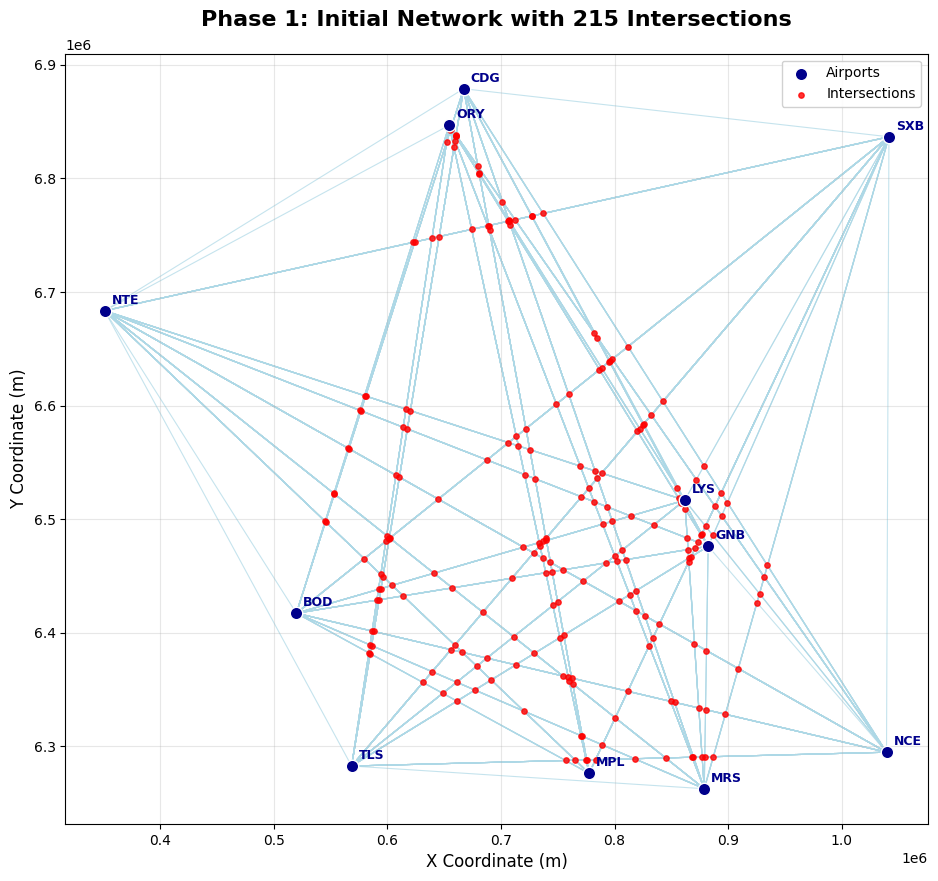


--------------------------------------------------------------------------------
Phase 2: Network Complexity Reduction via Clustering
--------------------------------------------------------------------------------
Searching for optimal k in range 100 down to 51...
Using binary search for efficiency...
   Testing k = 76... 	Max sector flux: 86
   Testing k = 63... 	Max sector flux: 105
   Testing k = 70... 	Max sector flux: 95
   Testing k = 67... 	Max sector flux: 99
   Testing k = 65... 	Max sector flux: 102
   Testing k = 66... 	Max sector flux: 101

Found valid k = 67 (max sector flux: 99 < 100)

Building reduced network with k=67 consolidated intersections...
Phase 2 Results:
  - Number of consolidated intersections: 67
  - Total intersections removed: 148
  - Network complexity reduction: 68.8%
Plot saved to: results/phase2_reduced_network.png


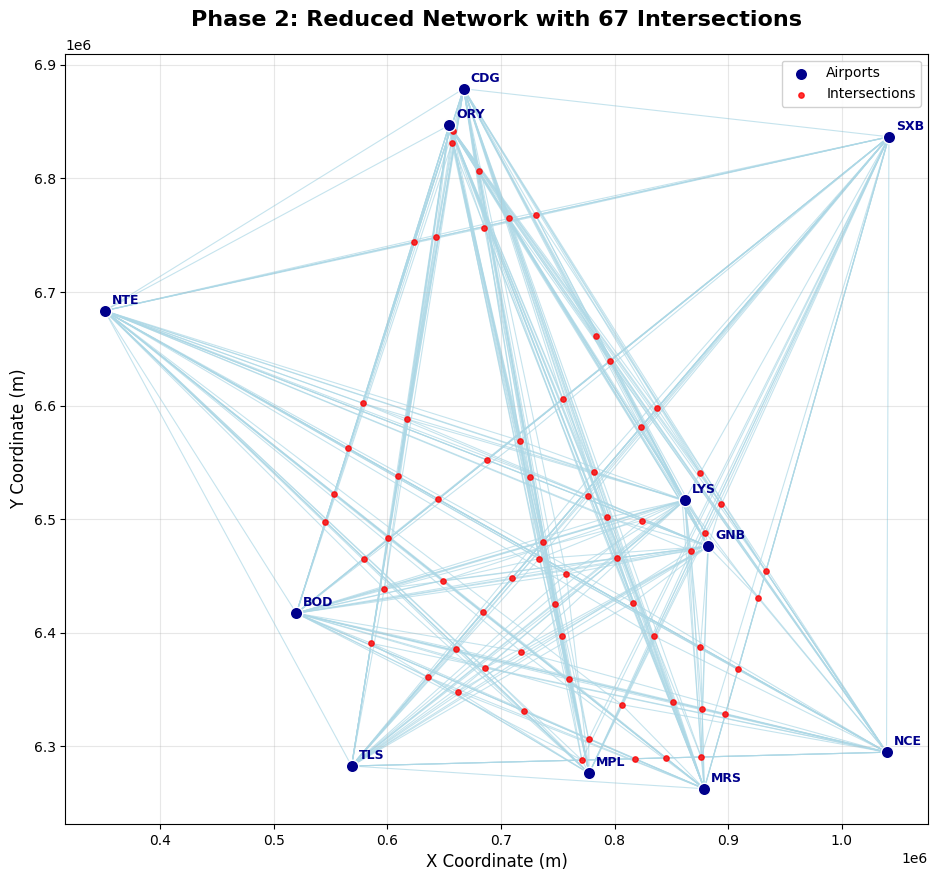


--------------------------------------------------------------------------------
Phase 3: Multi-Objective Position Optimization
--------------------------------------------------------------------------------
Pre-Optimization Metrics:
  - Airline Cost Index: 469,546,695
  - Network Dangerousness Index: 222,442,060,700
Starting iterative position optimization (50 iterations)...
   Completed iteration 10/50
   Iteration 10: Recalculating traffic flux...
   Completed iteration 20/50
   Iteration 20: Recalculating traffic flux...
   Completed iteration 30/50
   Iteration 30: Recalculating traffic flux...
   Completed iteration 40/50
   Iteration 40: Recalculating traffic flux...
   Completed iteration 50/50
Position optimization complete!

Post-Optimization Metrics:
  - Final Airline Cost Index: 471,105,215 (Change: +0.3%)
  - Final Dangerousness Index: 94,151,869,047 (Change: -57.7%)
Plot saved to: results/phase3_final_network.png


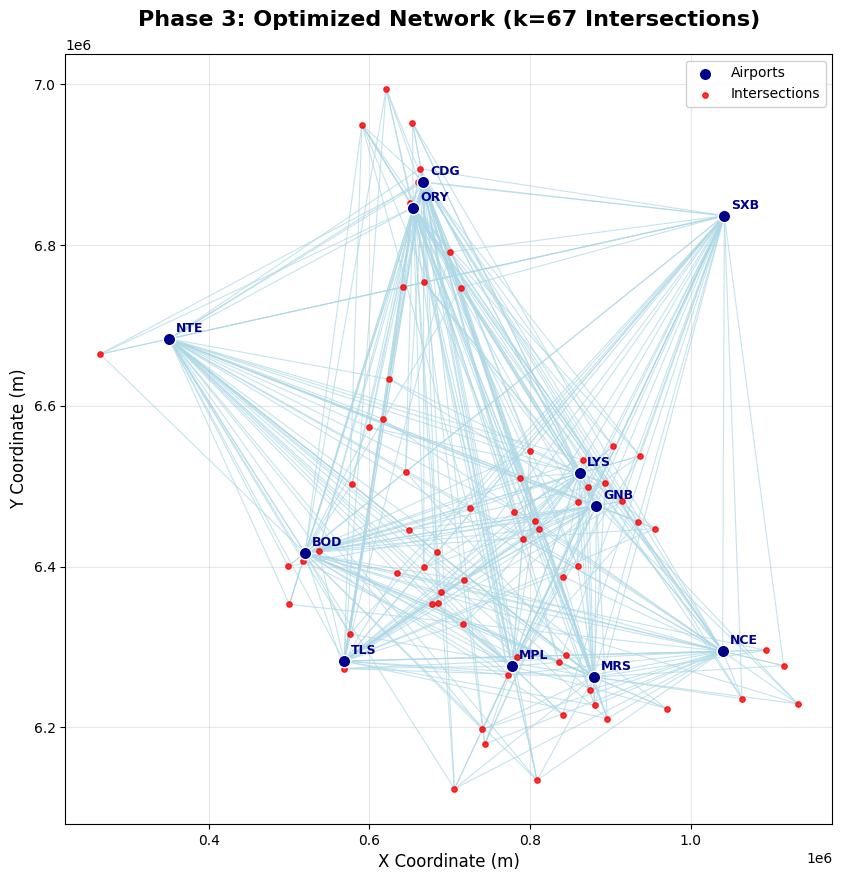

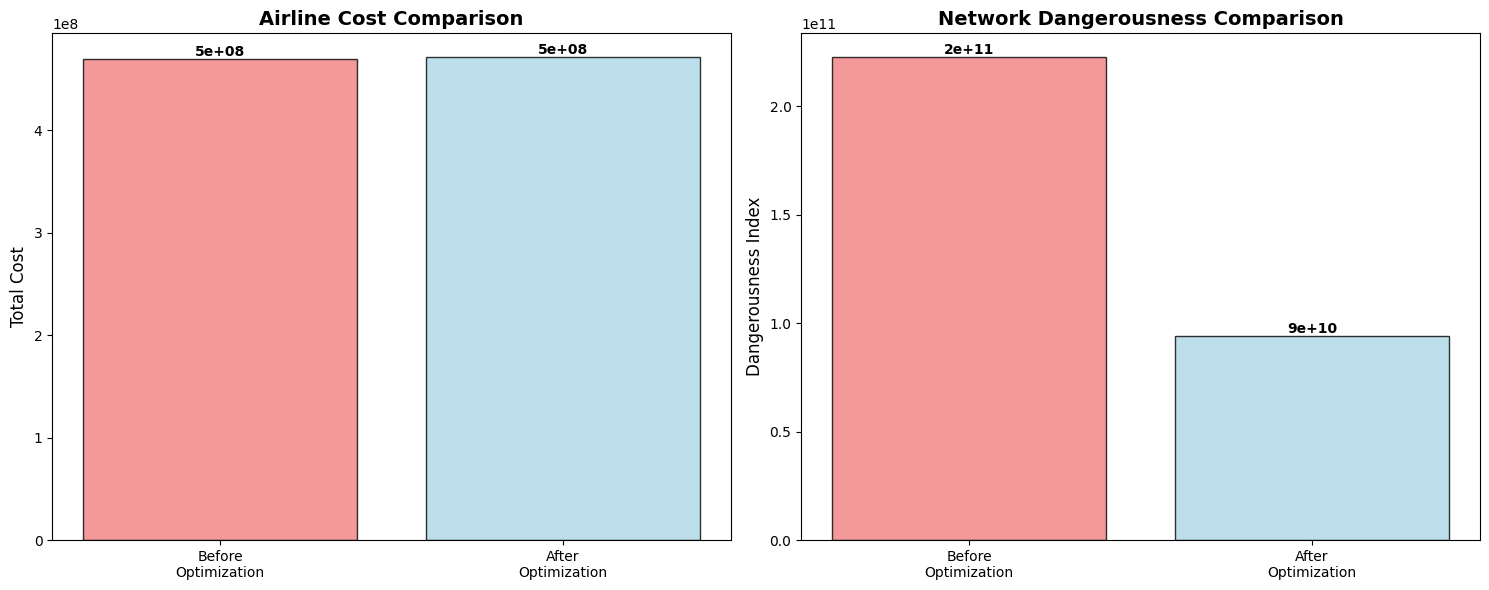


Optimization Process Complete: Final Report
Final Network Configuration:
  - Airports: 11
  - Optimized Intersections (Control Points): 67
  - Total Routes in Final Network: 403

Overall Performance Change:
  - Airline Cost: +0.3%
  - Network Dangerousness: -57.7%

All generated reports and visualizations have been saved to the 'results/' directory.


In [111]:
def main():
    """
    Executes the complete three-phase air route optimization algorithm.
    """
    # --- Introduction ---
    print("\n" + "="*80)
    print("Air Route Optimizer: Applied for France")
    print("="*80)

    # --- Initialization ---
    print("\nInitializing: Loading and processing input data...")
    airport_positions, traffic_demand, airport_codes = load_data(AIRPORTS_FILE, TRAFFIC_FILE)

    if airport_positions is None:
        print("\nError: Failed to load data. Please verify the integrity of data files.")
        return

    print(f"Initialization complete: {len(airport_codes)} airports loaded.")
    print(f"Total daily traffic demand: {np.sum(traffic_demand)} flights.")

    # --- Phase 1: Initial Network Generation ---
    print("\n" + "-"*80)
    print("Phase 1: Initial Network Generation")
    print("-"*80)
    initial_trajectories = determine_initial_trajectories(traffic_demand)
    initial_all_positions, initial_routes = create_initial_network(
        airport_positions, initial_trajectories)
    initial_network_matrix = create_adjacency_matrix(initial_all_positions, initial_routes)

    num_airports = len(airport_positions)
    num_initial_intersections = len(initial_all_positions) - num_airports

    print("Phase 1 Results:")
    print(f"  - Initial intersection points identified: {num_initial_intersections}")
    print(f"  - Total network nodes (airports + intersections): {len(initial_all_positions)}")
    print(f"  - Total direct routes generated: {len(initial_routes)}")

    plot_network(initial_all_positions, initial_routes, airport_codes,
                 title=f"Phase 1: Initial Network with {num_initial_intersections} Intersections",
                 save_path=os.path.join(RESULTS_DIR, 'phase1_initial_network.png'))

    # --- Phase 2: Network Complexity Reduction ---
    print("\n" + "-"*80)
    print("Phase 2: Network Complexity Reduction via Clustering")
    print("-"*80)
    if num_initial_intersections > 0:
        initial_intersection_positions = initial_all_positions[num_airports:]

        optimal_k = optimal_k = find_optimal_k(
    intersections=initial_intersection_positions,
    k_range=OPTIMAL_K_SEARCH_RANGE,
    flux_threshold=FLUX_THRESHOLD
)

        print(f"\nBuilding reduced network with k={optimal_k} consolidated intersections...")
        reduced_intersection_positions, labels = partition_intersections(
            np.array(initial_intersection_positions), optimal_k)

        reduced_network_matrix = create_reduced_network(
            airport_positions, reduced_intersection_positions, labels, initial_network_matrix)

        reduced_all_positions = airport_positions + reduced_intersection_positions.tolist()
        reduced_routes = [
            [i, j] for i in range(len(reduced_all_positions))
            for j in range(i + 1, len(reduced_all_positions))
            if reduced_network_matrix[i, j] == 1
        ]

        print("Phase 2 Results:")
        print(f"  - Number of consolidated intersections: {optimal_k}")
        print(f"  - Total intersections removed: {num_initial_intersections - optimal_k}")
        print(f"  - Network complexity reduction: {(1 - optimal_k/max(num_initial_intersections, 1)):.1%}")

        plot_network(reduced_all_positions, reduced_routes, airport_codes,
                     title=f"Phase 2: Reduced Network with {optimal_k} Intersections",
                     save_path=os.path.join(RESULTS_DIR, 'phase2_reduced_network.png'))
    else:
        print("No initial intersections found. Phase 2 will be skipped.")
        reduced_all_positions = airport_positions
        reduced_network_matrix = initial_network_matrix[:num_airports, :num_airports]
        reduced_routes = initial_routes
        optimal_k = 0

    # --- Phase 3: Multi-Objective Position Optimization ---
    print("\n" + "-"*80)
    print("Phase 3: Multi-Objective Position Optimization")
    print("-"*80)
    if optimal_k > 0:
        dist_matrix_before = calculate_route_distances(reduced_all_positions, reduced_network_matrix)
        flux_matrix_before = calculate_route_flux(traffic_demand, initial_trajectories, dist_matrix_before)
        cost_before = evaluate_airline_cost(dist_matrix_before, flux_matrix_before)
        danger_before = evaluate_network_dangerousness(
            reduced_all_positions, num_airports, reduced_network_matrix, flux_matrix_before)

        print("Pre-Optimization Metrics:")
        print(f"  - Airline Cost Index: {cost_before:,.0f}")
        print(f"  - Network Dangerousness Index: {danger_before:,.0f}")

        final_positions = run_iterative_optimization(
            reduced_all_positions, reduced_network_matrix, flux_matrix_before,
            num_airports, OPTIMIZATION_ITERATIONS, traffic_demand, initial_trajectories,
            COST_STEP, DANGER_STEP
        )

        dist_matrix_after = calculate_route_distances(final_positions, reduced_network_matrix)
        flux_matrix_after = calculate_route_flux(traffic_demand, initial_trajectories, dist_matrix_after)
        cost_after = evaluate_airline_cost(dist_matrix_after, flux_matrix_after)
        danger_after = evaluate_network_dangerousness(
            final_positions, num_airports, reduced_network_matrix, flux_matrix_after)

        print("\nPost-Optimization Metrics:")
        print(f"  - Final Airline Cost Index: {cost_after:,.0f} (Change: {((cost_after - cost_before) / cost_before * 100):+.1f}%)")
        print(f"  - Final Dangerousness Index: {danger_after:,.0f} (Change: {((danger_after - danger_before) / max(danger_before, 1) * 100):+.1f}%)")

        plot_network(final_positions, reduced_routes, airport_codes,
                     title=f"Phase 3: Optimized Network (k={optimal_k} Intersections)",
                     save_path=os.path.join(RESULTS_DIR, 'phase3_final_network.png'))
        create_comparison_plot(cost_before, cost_after, danger_before, danger_after)

    else:
        print("No intersections to optimize. Phase 3 will be skipped.")
        final_positions = reduced_all_positions
        cost_before = cost_after = 0
        danger_before = danger_after = 0

    # --- Final Summary ---
    print("\n" + "="*80)
    print("Optimization Process Complete: Final Report")
    print("="*80)
    print("Final Network Configuration:")
    print(f"  - Airports: {num_airports}")
    print(f"  - Optimized Intersections (Control Points): {optimal_k}")
    print(f"  - Total Routes in Final Network: {len(reduced_routes)}")

    if optimal_k > 0:
        print("\nOverall Performance Change:")
        print(f"  - Airline Cost: {((cost_after - cost_before) / cost_before * 100):+.1f}%")
        print(f"  - Network Dangerousness: {((danger_after - danger_before) / max(danger_before, 1) * 100):+.1f}%")

    print(f"\nAll generated reports and visualizations have been saved to the '{RESULTS_DIR}/' directory.")

    return {
        'airport_positions': airport_positions,
        'traffic_demand': traffic_demand,
        'airport_codes': airport_codes,
        'initial_intersections': num_initial_intersections,
        'optimal_k': optimal_k,
        'final_positions': final_positions,
        'network_matrix': reduced_network_matrix,
        'cost_before': cost_before if optimal_k > 0 else None,
        'cost_after': cost_after if optimal_k > 0 else None,
        'danger_before': danger_before if optimal_k > 0 else None,
        'danger_after': danger_after if optimal_k > 0 else None
    }

def create_comparison_plot(cost_before, cost_after, danger_before, danger_after):
    """
    Create a comparison plot showing cost vs dangerousness before/after optimization.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Cost comparison
    categories = ['Before\nOptimization', 'After\nOptimization']
    costs = [cost_before, cost_after]
    colors = ['lightcoral', 'lightblue']
    
    bars1 = ax1.bar(categories, costs, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Airline Cost Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Total Cost', fontsize=12)
    ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Add value labels on bars
    for bar, cost in zip(bars1, costs):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{cost:.0e}', ha='center', va='bottom', fontweight='bold')
    
    # Dangerousness comparison
    dangers = [danger_before, danger_after]
    bars2 = ax2.bar(categories, dangers, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('Network Dangerousness Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Dangerousness Index', fontsize=12)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Add value labels on bars
    for bar, danger in zip(bars2, dangers):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{danger:.0e}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'optimization_comparison.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

    # Execute the main optimization pipeline
if __name__ == "__main__":
    # Run the complete optimization
    results = main()
    
    